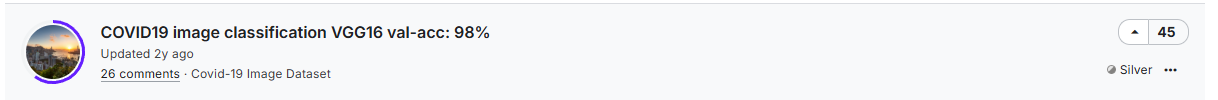

In [1]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'D:\code_study\ML_CODE\dataSets\Covid-19_Image_Dataset\Covid19-dataset/train'
TRAINING_DIR = TRAINING_DIR.replace('\\', '/')
TESTING_DIR = 'D:\code_study\ML_CODE\dataSets\Covid-19_Image_Dataset\Covid19-dataset/test'
TESTING_DIR = TESTING_DIR.replace('\\', '/')

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


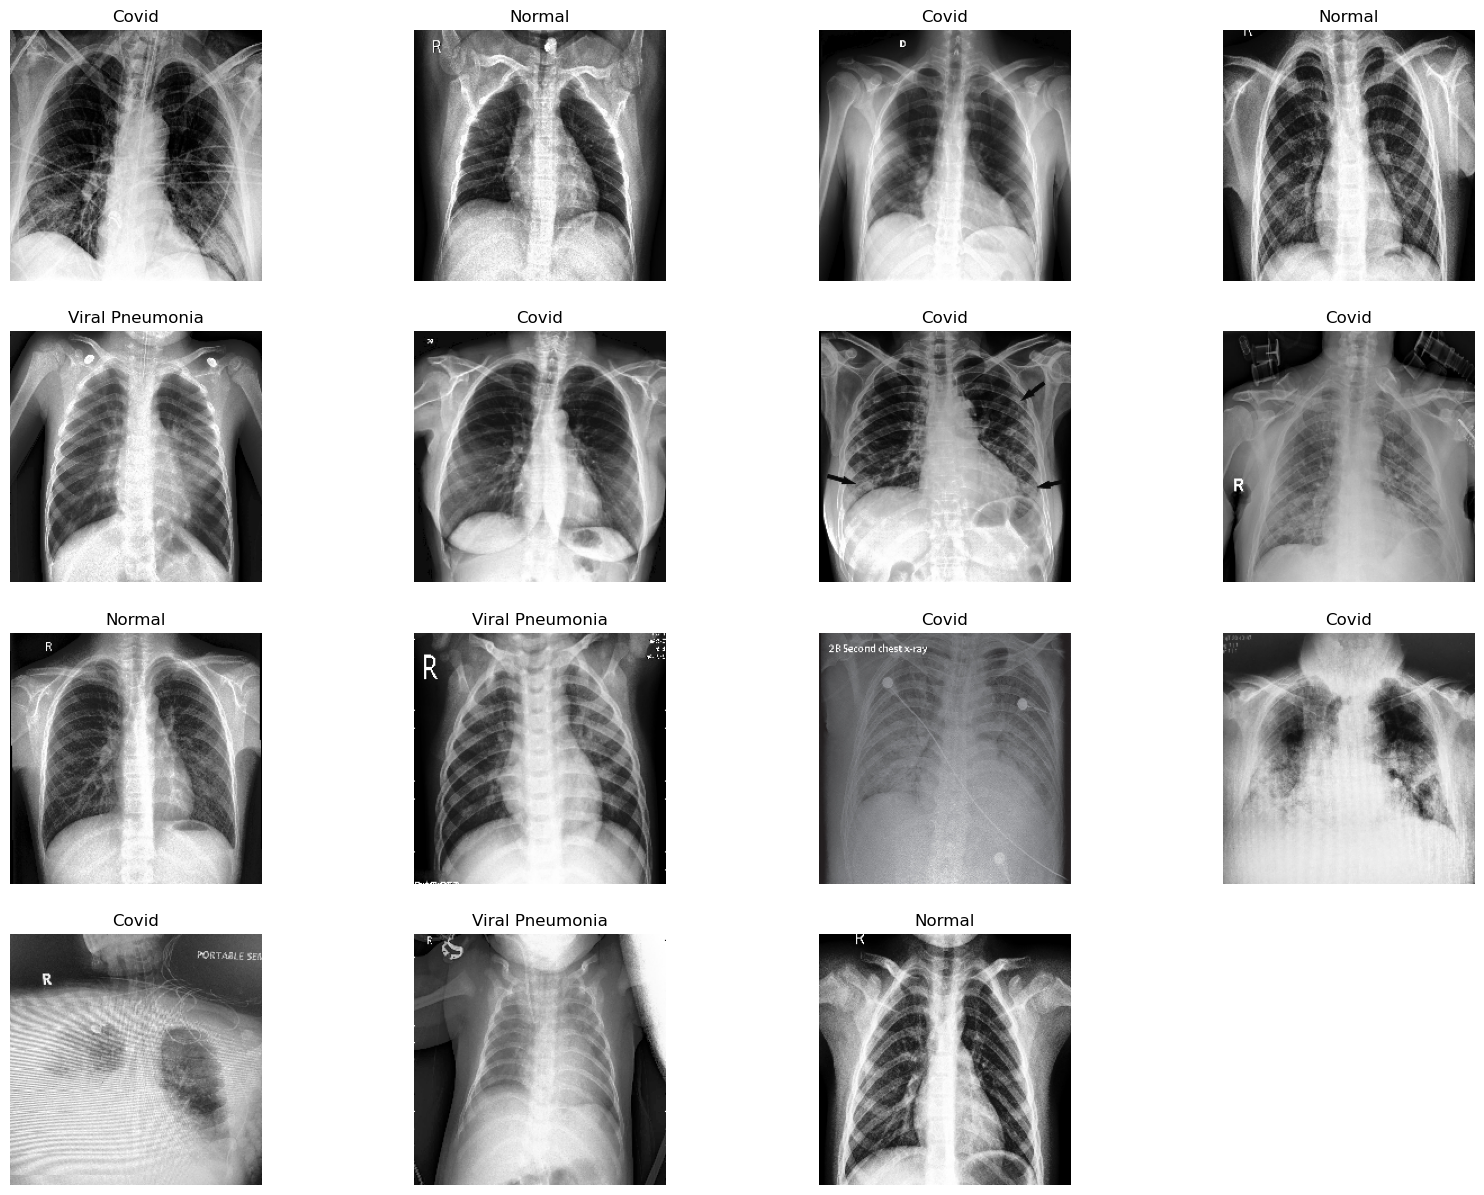

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [4]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - 46s 9s/step - loss: 1.2412 - acc: 0.3723 - val_loss: 1.0450 - val_acc: 0.3939

Epoch 00001: acc improved from -inf to 0.38645, saving model to model\vgg16_best.h5
Epoch 2/50
4/4 [==============================] - 4s 859ms/step - loss: 1.1552 - acc: 0.4154 - val_loss: 0.9682 - val_acc: 0.3939

Epoch 00002: acc improved from 0.38645 to 0.43426, saving model to model\vgg16_best.h5
Epoch 3/50
4/4 [==============================] - 12s 1s/step - loss: 0.9733 - acc: 0.5483 - val_loss: 0.8984 - val_acc: 0.6515

Epoch 00003: acc improved from 0.43426 to 0.52191, saving model to model\vgg16_best.h5
Epoch 4/50
4/4 [==============================] - 17s 5s/step - loss: 0.9145 - acc: 0.5391 - val_loss: 0.8213 - val_acc: 0.7424

Epoch 00004: acc improved from 0.52191 to 0.53386, saving model to model\vgg16_best.h5
Epoch 5/50
4/4 [==============================] - 6s 975ms/step - loss: 0.8648 - acc: 0.6211 - val_loss: 0.7375 - val_acc: 0.7879

Epoch 

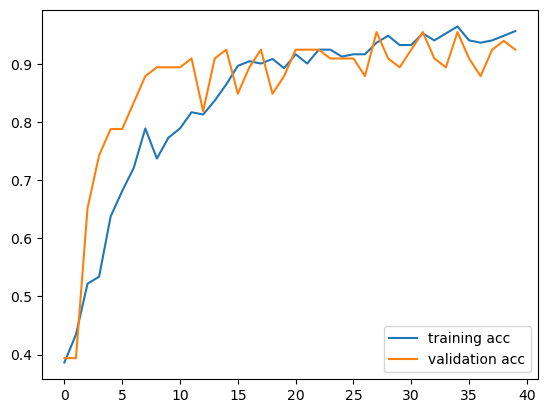

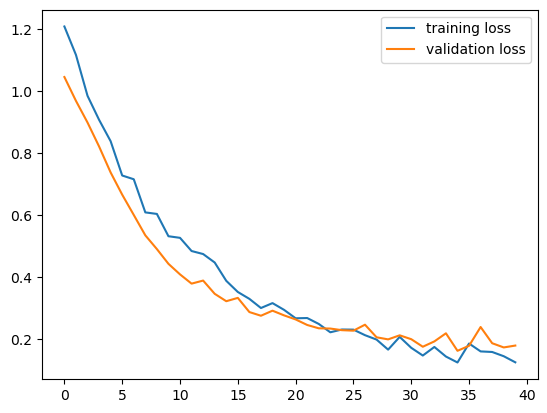

In [6]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [7]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 3s 26ms/step - loss: 0.1631 - acc: 0.9545


,Train,Val
Loss,0.099488,0.163104
Acc,0.968127,0.954545


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.95      0.90      0.92        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



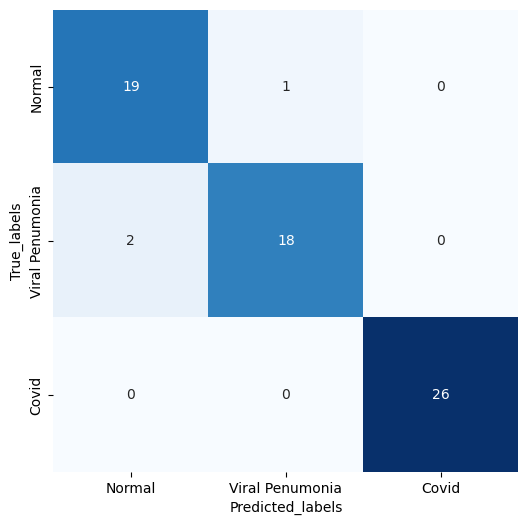

In [8]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

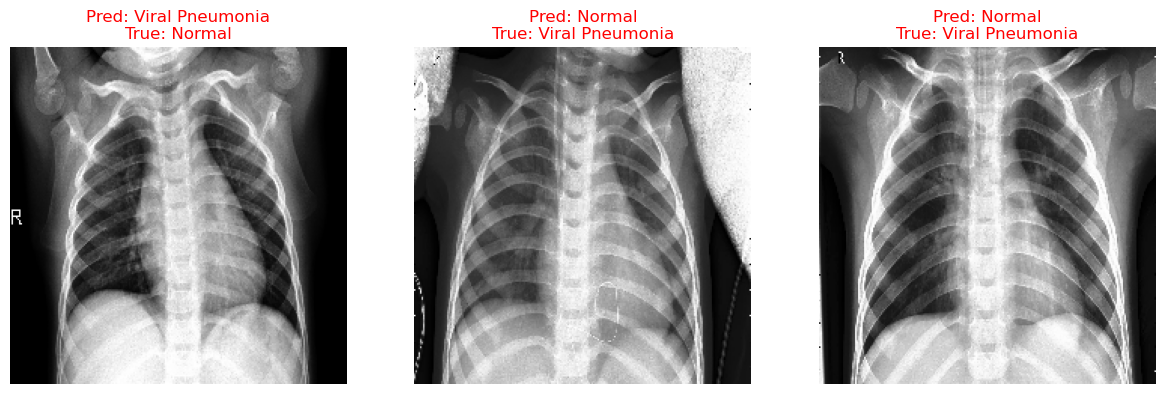

In [9]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]
# Define a dictionary for labels
label_dict = {0: "Normal", 1: "Viral Pneumonia", 2: "Covid"}

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    predicted_label = label_dict.get(ypred[n], "Unknown")
    true_label = label_dict.get(ytest[n], "Unknown")
    #plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color='r')
    plt.axis("off")

Found 251 images belonging to 3 classes.


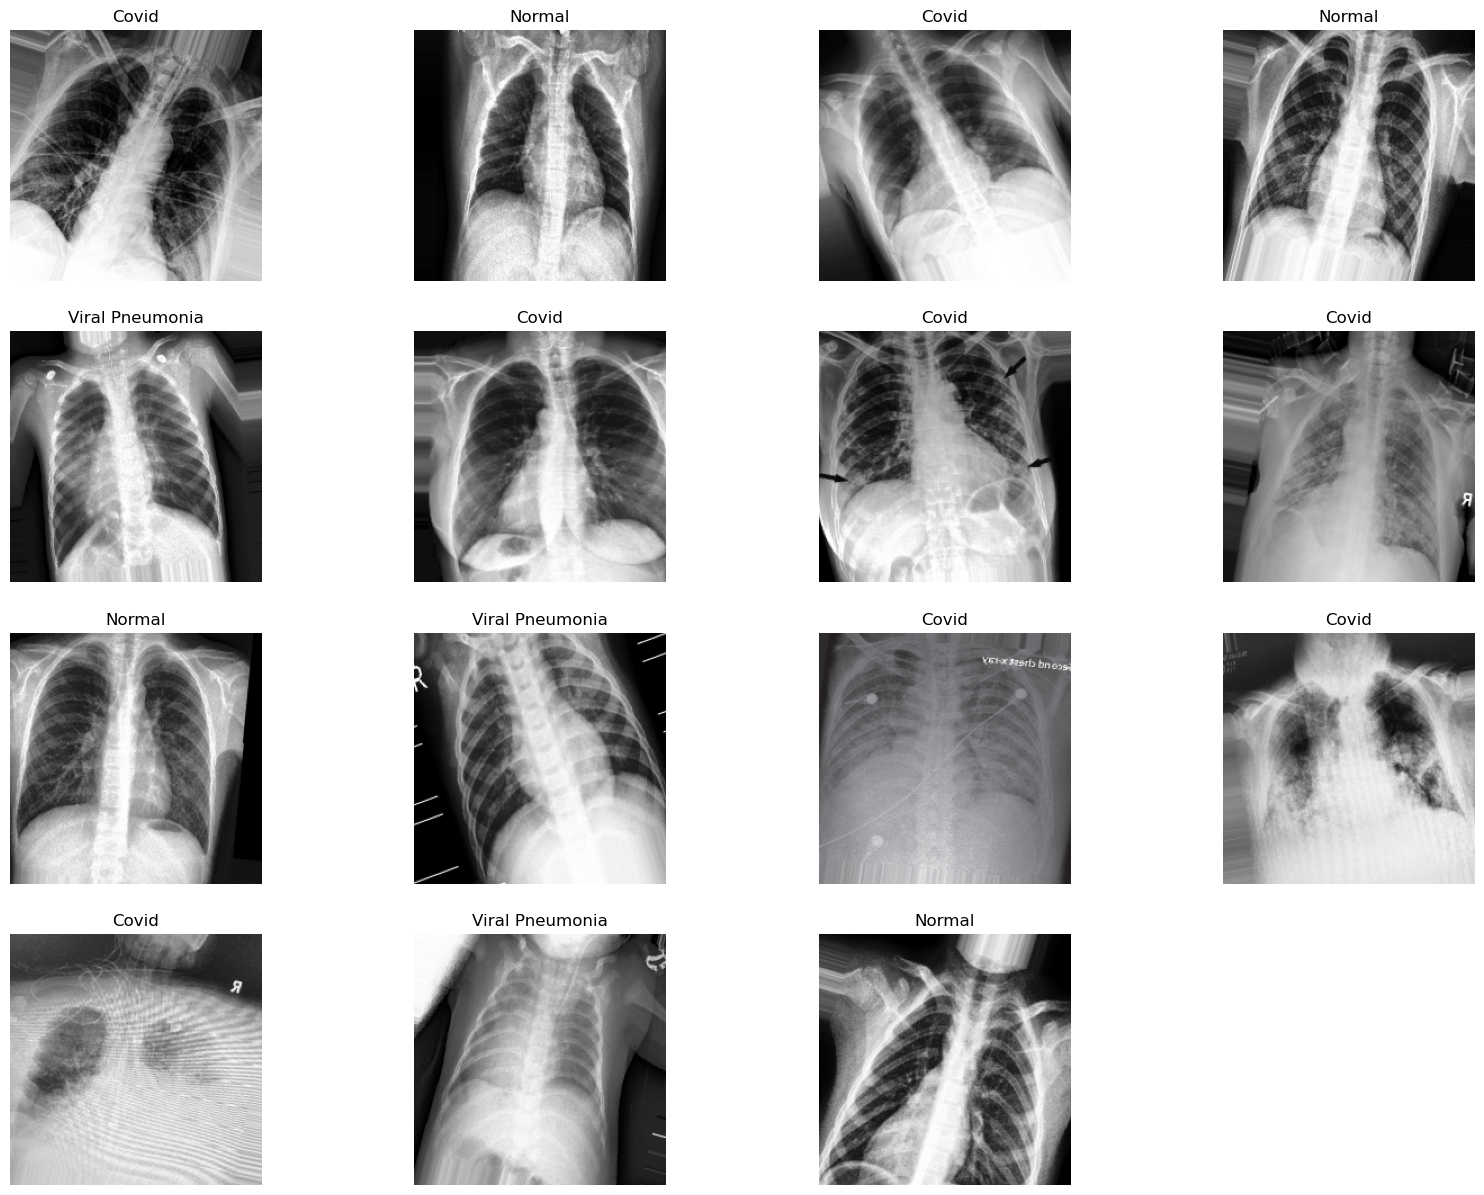

In [10]:
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,15)

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=60, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/60
4/4 [==============================] - 8s 2s/step - loss: 0.2464 - acc: 0.9124 - val_loss: 0.1908 - val_acc: 0.9242

Epoch 00001: acc improved from -inf to 0.91235, saving model to model\vgg16_best.h5
Epoch 2/60
4/4 [==============================] - 5s 1s/step - loss: 0.2936 - acc: 0.8606 - val_loss: 0.1591 - val_acc: 0.9394

Epoch 00002: acc did not improve from 0.91235
Epoch 3/60
4/4 [==============================] - 5s 1s/step - loss: 0.2839 - acc: 0.8725 - val_loss: 0.1627 - val_acc: 0.9394

Epoch 00003: acc did not improve from 0.91235
Epoch 4/60
4/4 [==============================] - 6s 2s/step - loss: 0.2654 - acc: 0.9044 - val_loss: 0.2238 - val_acc: 0.9091

Epoch 00004: acc did not improve from 0.91235
Epoch 5/60
4/4 [==============================] - 5s 1s/step - loss: 0.2912 - acc: 0.9044 - val_loss: 0.1649 - val_acc: 0.9545

Epoch 00005: acc did not improve from 0.91235
Epoch 6/60
4/4 [==============================] - 15s 5s/step - loss: 0.2515 - acc: 0.9163 -

In [12]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 4s 14ms/step - loss: 0.1084 - acc: 0.9848


,Train,Val
Loss,0.060764,0.108382
Acc,0.980080,0.984848


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        70
         1.0       0.99      0.94      0.96        70
         2.0       1.00      1.00      1.00       111

    accuracy                           0.98       251
   macro avg       0.98      0.98      0.98       251
weighted avg       0.98      0.98      0.98       251



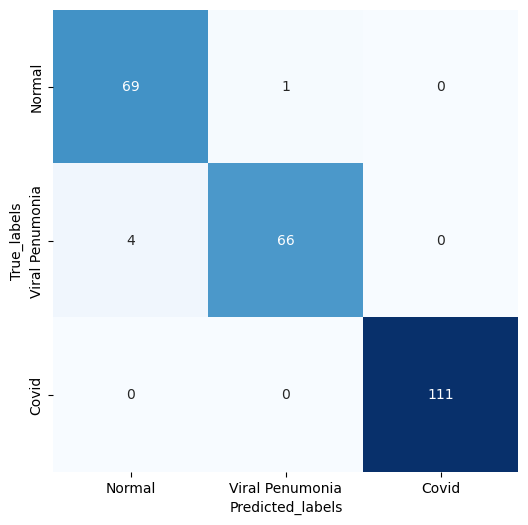

In [13]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.95      1.00      0.98        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



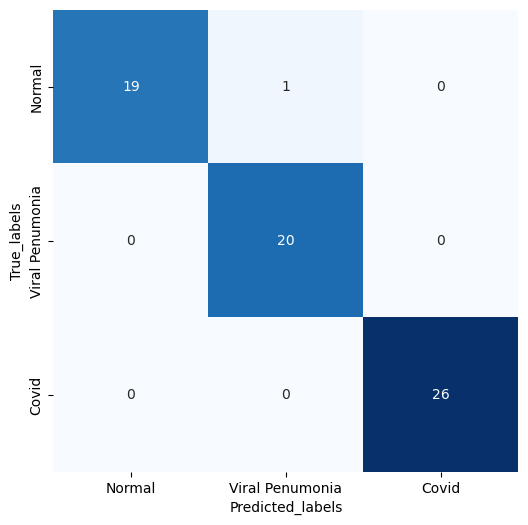

In [14]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))